# 참외 병해 예측(분류) 모델 만들기

## 지능형 스마트팜(참외) 데이터
- [AI Hub 지능형 스마트팜(참외) 데이터](https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=&topMenu=&aihubDataSe=data&dataSetSn=71344)
- 참외 재배 시 발생하는 노균병, 흰가루병의 진단을 목적으로 노균병, 노균병유사, 흰가루병, 흰가루병유사, 정상 이미지를 인공지능 학습하여 질병과 질병의 유사 형상 및 정상 이미지를 비교해 질병의 정확한 진단을 가능하게 함

**corps_info**
- set_meal_dt: 식사 세트 날짜 (비료나 물을 준 날짜)
- grdp_step: 생육 단계

**image**
- class_name: 병해 유형 이름

**environments** : 각 환경 요소에 대한 데이터가 시간별로 기록
- evrmnt_id: 환경 데이터의 ID
- inr_tp: 내부 온도 (°C)
- inr_hd: 내부 습도 (%)
- co2: CO2 농도 (ppm)
- amnt_of_slr_rdt: 일사량 (W/m²)
- soil_ec: 토양 전기 전도도 (dS/m)
- soil_tp: 토양 온도 (°C)
- soil_hd: 토양 습도 (%)
- rain: 강수 유무
- extrnl_tp: 외부 온도 (°C)
- extrnl_hd: 외부 습도 (%)
- receive_dt: 데이터 수신 시간

In [ ]:
# 코랩에서 한글 안보이는 현상 (설치후 런타임->세션 다시시작)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib

matplotlib.rcParams['axes.unicode_minus'] = False
# plt.rcParams['font.family'] = 'Malgun Gothic'  # (Windows 용)
plt.rc('font', family='NanumBarunGothic') # (Colab 용)
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

## 1. 데이터 가져오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
rootdir = '/content/drive/MyDrive/2025_SeSAC/ statistics/data/'
melon = pd.read_csv(rootdir+'melon_environment.csv',sep=',')

## 2. 데이터 훑어보기

In [ ]:
melon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7280 entries, 0 to 7279
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   병해 유형      7280 non-null   object 
 1   생육 단계      7280 non-null   object 
 2   내부 온도      7280 non-null   float64
 3   내부 습도      7280 non-null   float64
 4   CO2 농도     7280 non-null   int64  
 5   일사량        7280 non-null   int64  
 6   토양 전기 전도도  7280 non-null   float64
 7   토양 온도      7280 non-null   float64
 8   토양 습도      7280 non-null   float64
 9   강수 유무      7280 non-null   object 
 10  외부 온도      7280 non-null   float64
 11  외부 습도      7280 non-null   float64
 12  데이터 수신시간   7280 non-null   object 
dtypes: float64(7), int64(2), object(4)
memory usage: 739.5+ KB


In [ ]:
melon.shape

(7280, 13)

In [ ]:
melon.head()

,병해 유형,생육 단계,내부 온도,내부 습도,CO2 농도,일사량,토양 전기 전도도,토양 온도,토양 습도,강수 유무,외부 온도,외부 습도,데이터 수신시간
0,노균병,정식,40.7,49.3,389,218,0.38,30.6,26.7,맑음,27.0,75.0,2022-07-05 12:00:00
1,노균병,정식,39.7,56.9,394,314,0.37,30.8,26.4,맑음,27.0,75.0,2022-07-05 12:30:00
2,노균병,정식,26.4,85.9,423,28,0.18,30.2,21.6,맑음,33.0,50.0,2022-07-06 06:00:00
3,노균병,정식,27.2,85.7,419,45,0.18,30.1,21.6,맑음,33.0,50.0,2022-07-06 06:30:00
4,노균병,정식,42.7,37.5,409,295,0.16,31.7,21.3,맑음,27.0,75.0,2022-07-07 15:00:00


## 3. 데이터 탐색

### 범주형 특성 탐색

In [ ]:
melon['병해 유형'].value_counts()

,count
병해 유형,
정상,3040
노균병,1460
흰가루병,1460
노균병유사,660
흰가루병유사,660


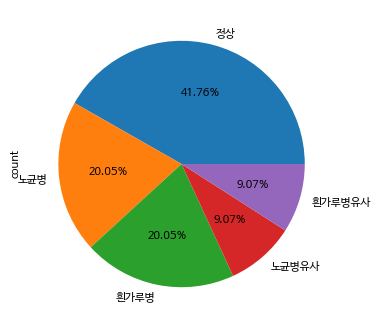

In [ ]:
plt.figure(figsize=(6, 4))
plt.rcParams['font.size'] = 8
data = melon['병해 유형'].value_counts()
data.plot(kind='pie', autopct="%.2f%%")
plt.show()

In [ ]:
melon['생육 단계'].value_counts()

,count
생육 단계,
정식,3304
수확,2422
착과,1554


In [ ]:
melon['강수 유무'].value_counts()

,count
강수 유무,
맑음,7095
비,185


In [ ]:
categorical_cols = melon.select_dtypes(include=['object']).columns.tolist()
categorical_data = melon[categorical_cols]
categorical_data

,병해 유형,생육 단계,강수 유무,데이터 수신시간
0,노균병,정식,맑음,2022-07-05 12:00:00
1,노균병,정식,맑음,2022-07-05 12:30:00
2,노균병,정식,맑음,2022-07-06 06:00:00
3,노균병,정식,맑음,2022-07-06 06:30:00
4,노균병,정식,맑음,2022-07-07 15:00:00
...,...,...,...,...
7275,흰가루병유사,착과,맑음,2022-08-08 03:00:00
7276,흰가루병유사,착과,맑음,2022-08-09 03:30:00
7277,흰가루병유사,착과,맑음,2022-08-09 04:00:00
7278,흰가루병유사,착과,맑음,2022-08-09 22:30:00


**범주형 특성 분석**
- 타깃 클래스(병해 유형)별 데이터 양이 다름
- 생육 단계별 빈도수가 다름
- 맑은 날이 비가 온 날보다 많음

### 수치형 특성 탐색

**히스토그램**

In [ ]:
melon.columns

Index(['병해 유형', '생육 단계', '내부 온도', '내부 습도', 'CO2 농도', '일사량', '토양 전기 전도도',
       '토양 온도', '토양 습도', '강수 유무', '외부 온도', '외부 습도', '데이터 수신시간'],
      dtype='object')

In [ ]:
numerical_cols = melon.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_data = melon[numerical_cols]
numeric_data

,내부 온도,내부 습도,CO2 농도,일사량,토양 전기 전도도,토양 온도,토양 습도,외부 온도,외부 습도
0,40.7,49.3,389,218,0.38,30.6,26.7,27.0,75.0
1,39.7,56.9,394,314,0.37,30.8,26.4,27.0,75.0
2,26.4,85.9,423,28,0.18,30.2,21.6,33.0,50.0
3,27.2,85.7,419,45,0.18,30.1,21.6,33.0,50.0
4,42.7,37.5,409,295,0.16,31.7,21.3,27.0,75.0
...,...,...,...,...,...,...,...,...,...
7275,24.6,94.0,529,0,0.09,29.7,16.9,24.6,92.0
7276,26.1,82.8,393,0,0.16,28.4,22.0,26.6,76.0
7277,26.1,82.5,392,0,0.16,28.4,22.0,26.5,76.0
7278,27.3,78.8,378,0,0.14,29.5,21.0,27.9,73.0


numerical_cols 다른 방법으로 가져오기

In [ ]:
melon.columns[2:9]

Index(['내부 온도', '내부 습도', 'CO2 농도', '일사량', '토양 전기 전도도', '토양 온도', '토양 습도'], dtype='object')

In [ ]:
melon.columns[-3:-1]

Index(['외부 온도', '외부 습도'], dtype='object')

In [ ]:
numeric_cloumns = list(melon.columns[2:9]) + list(melon.columns[-3:-1])

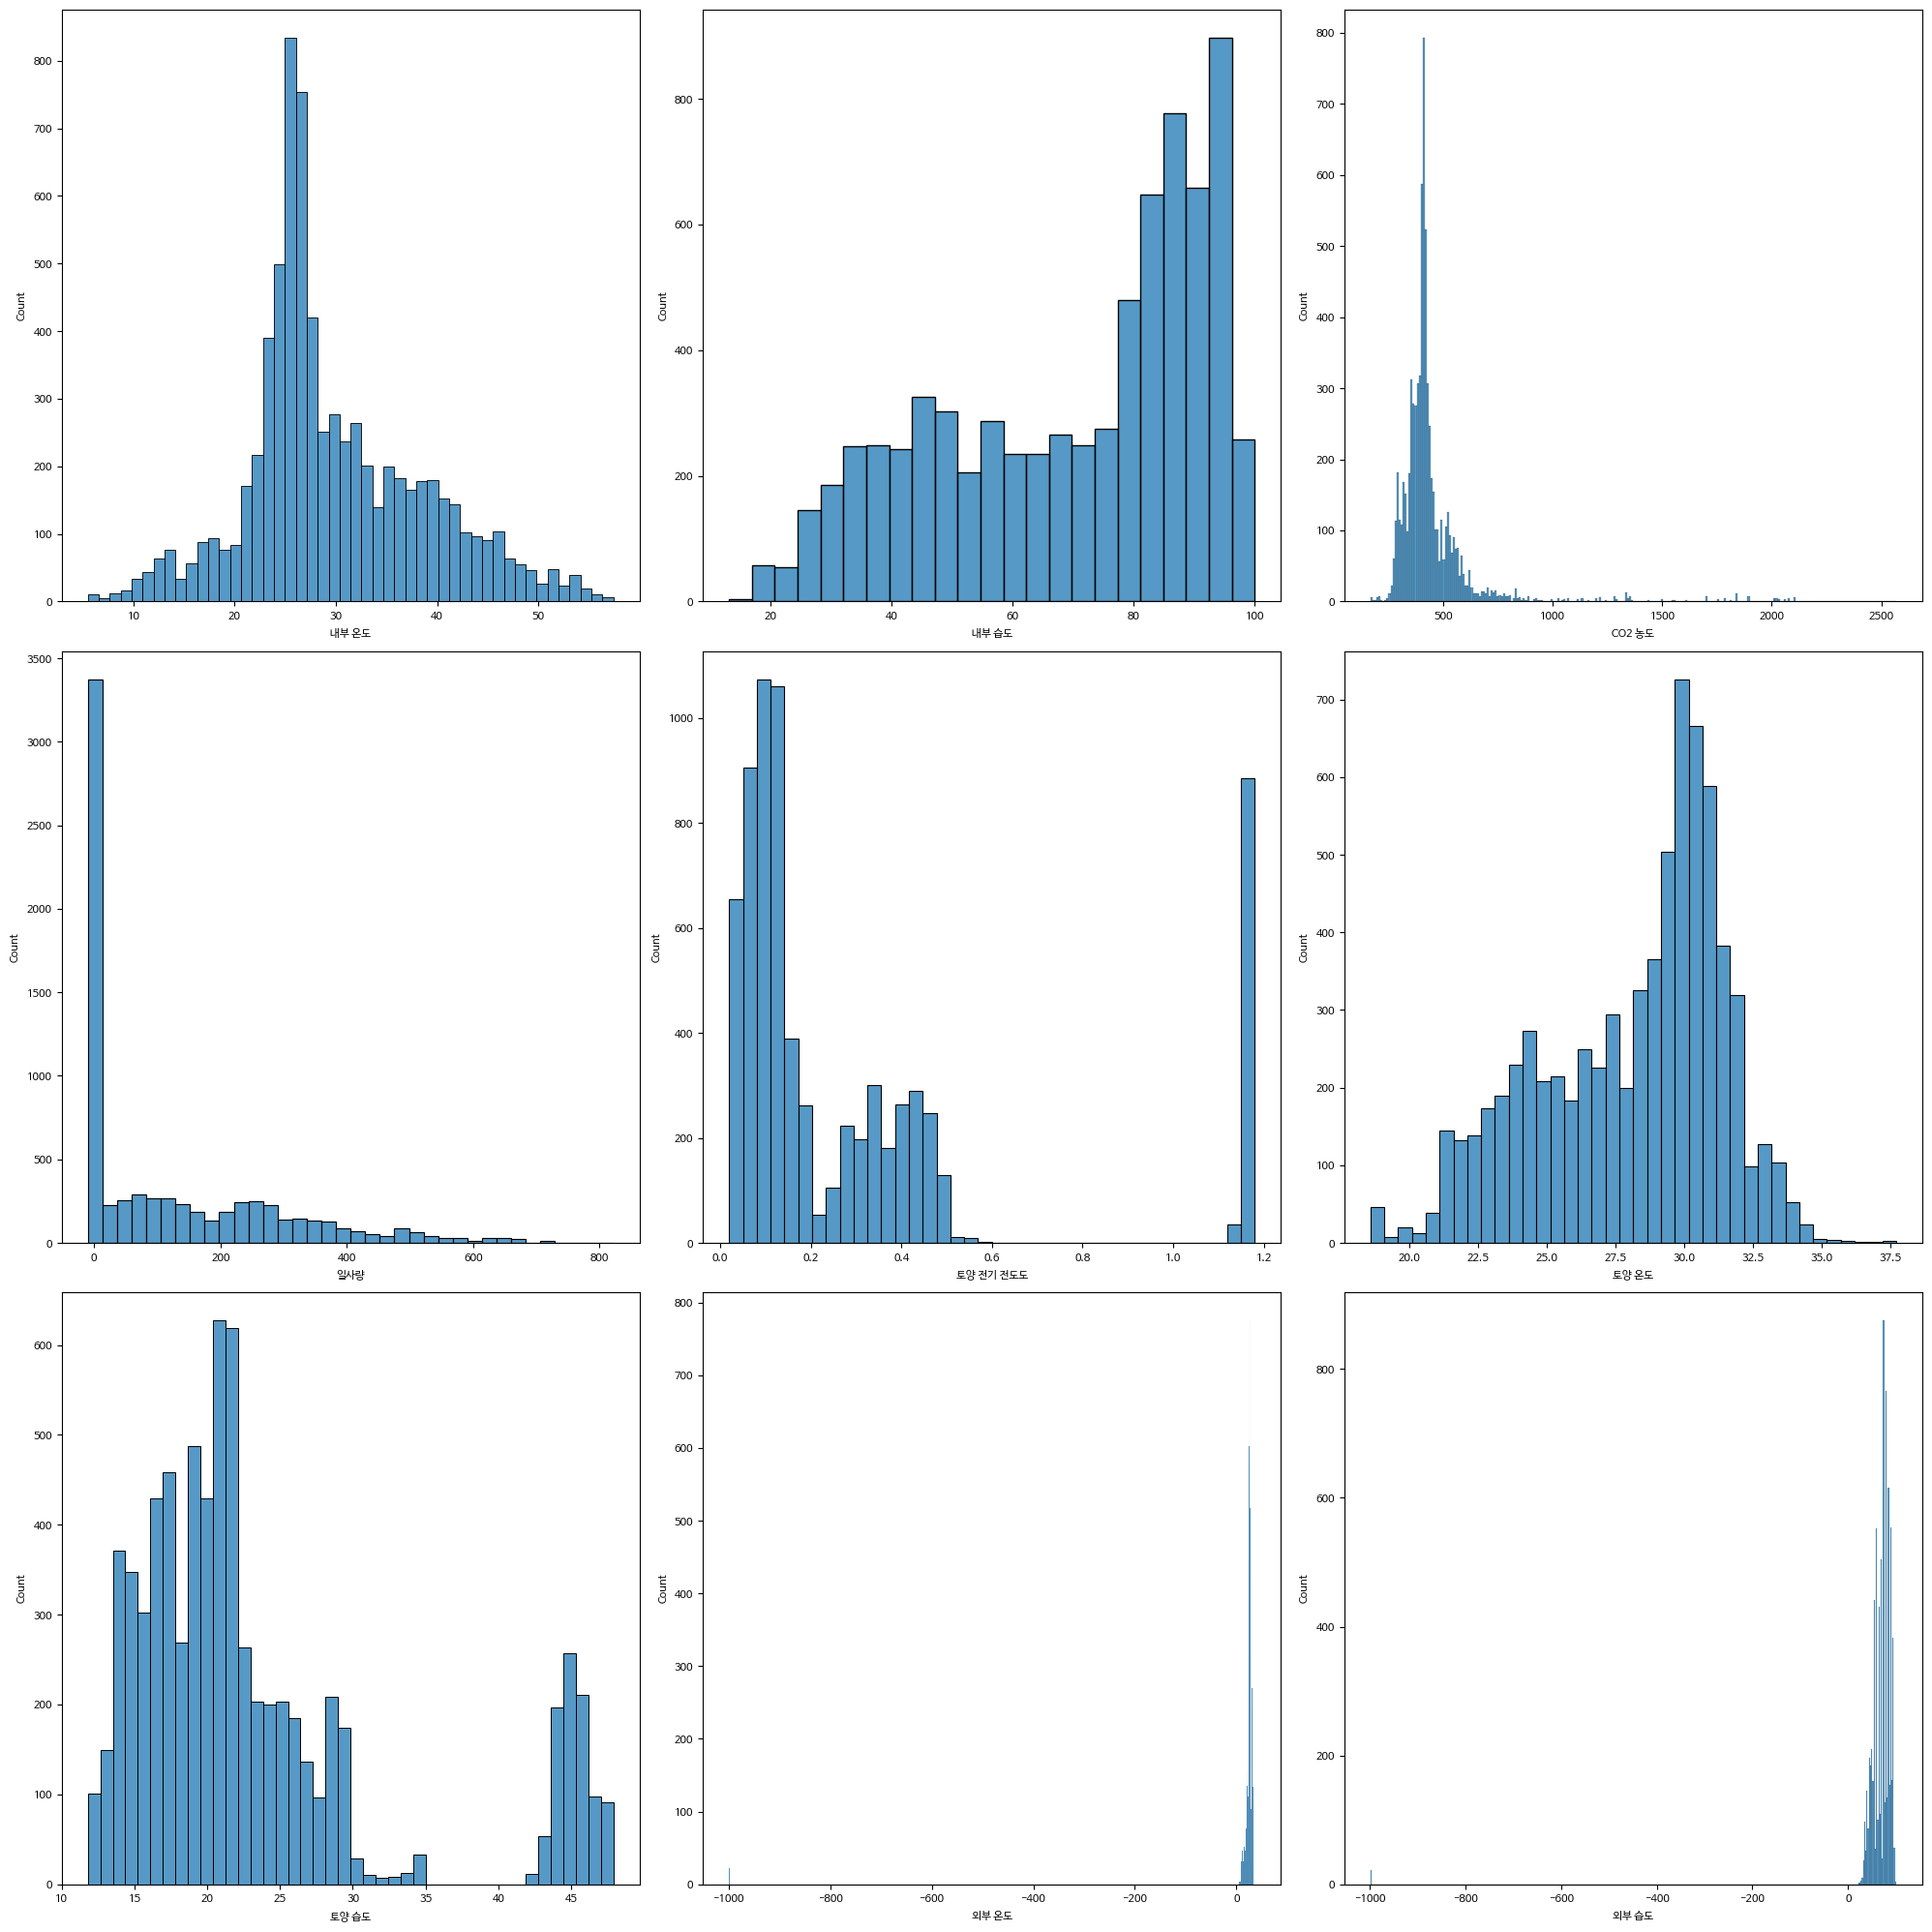

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,20))
axes = axes.flatten()

for i, column in enumerate(numeric_cloumns):
  sns.histplot(data=melon, x=column, ax=axes[i])

plt.tight_layout()
plt.show()

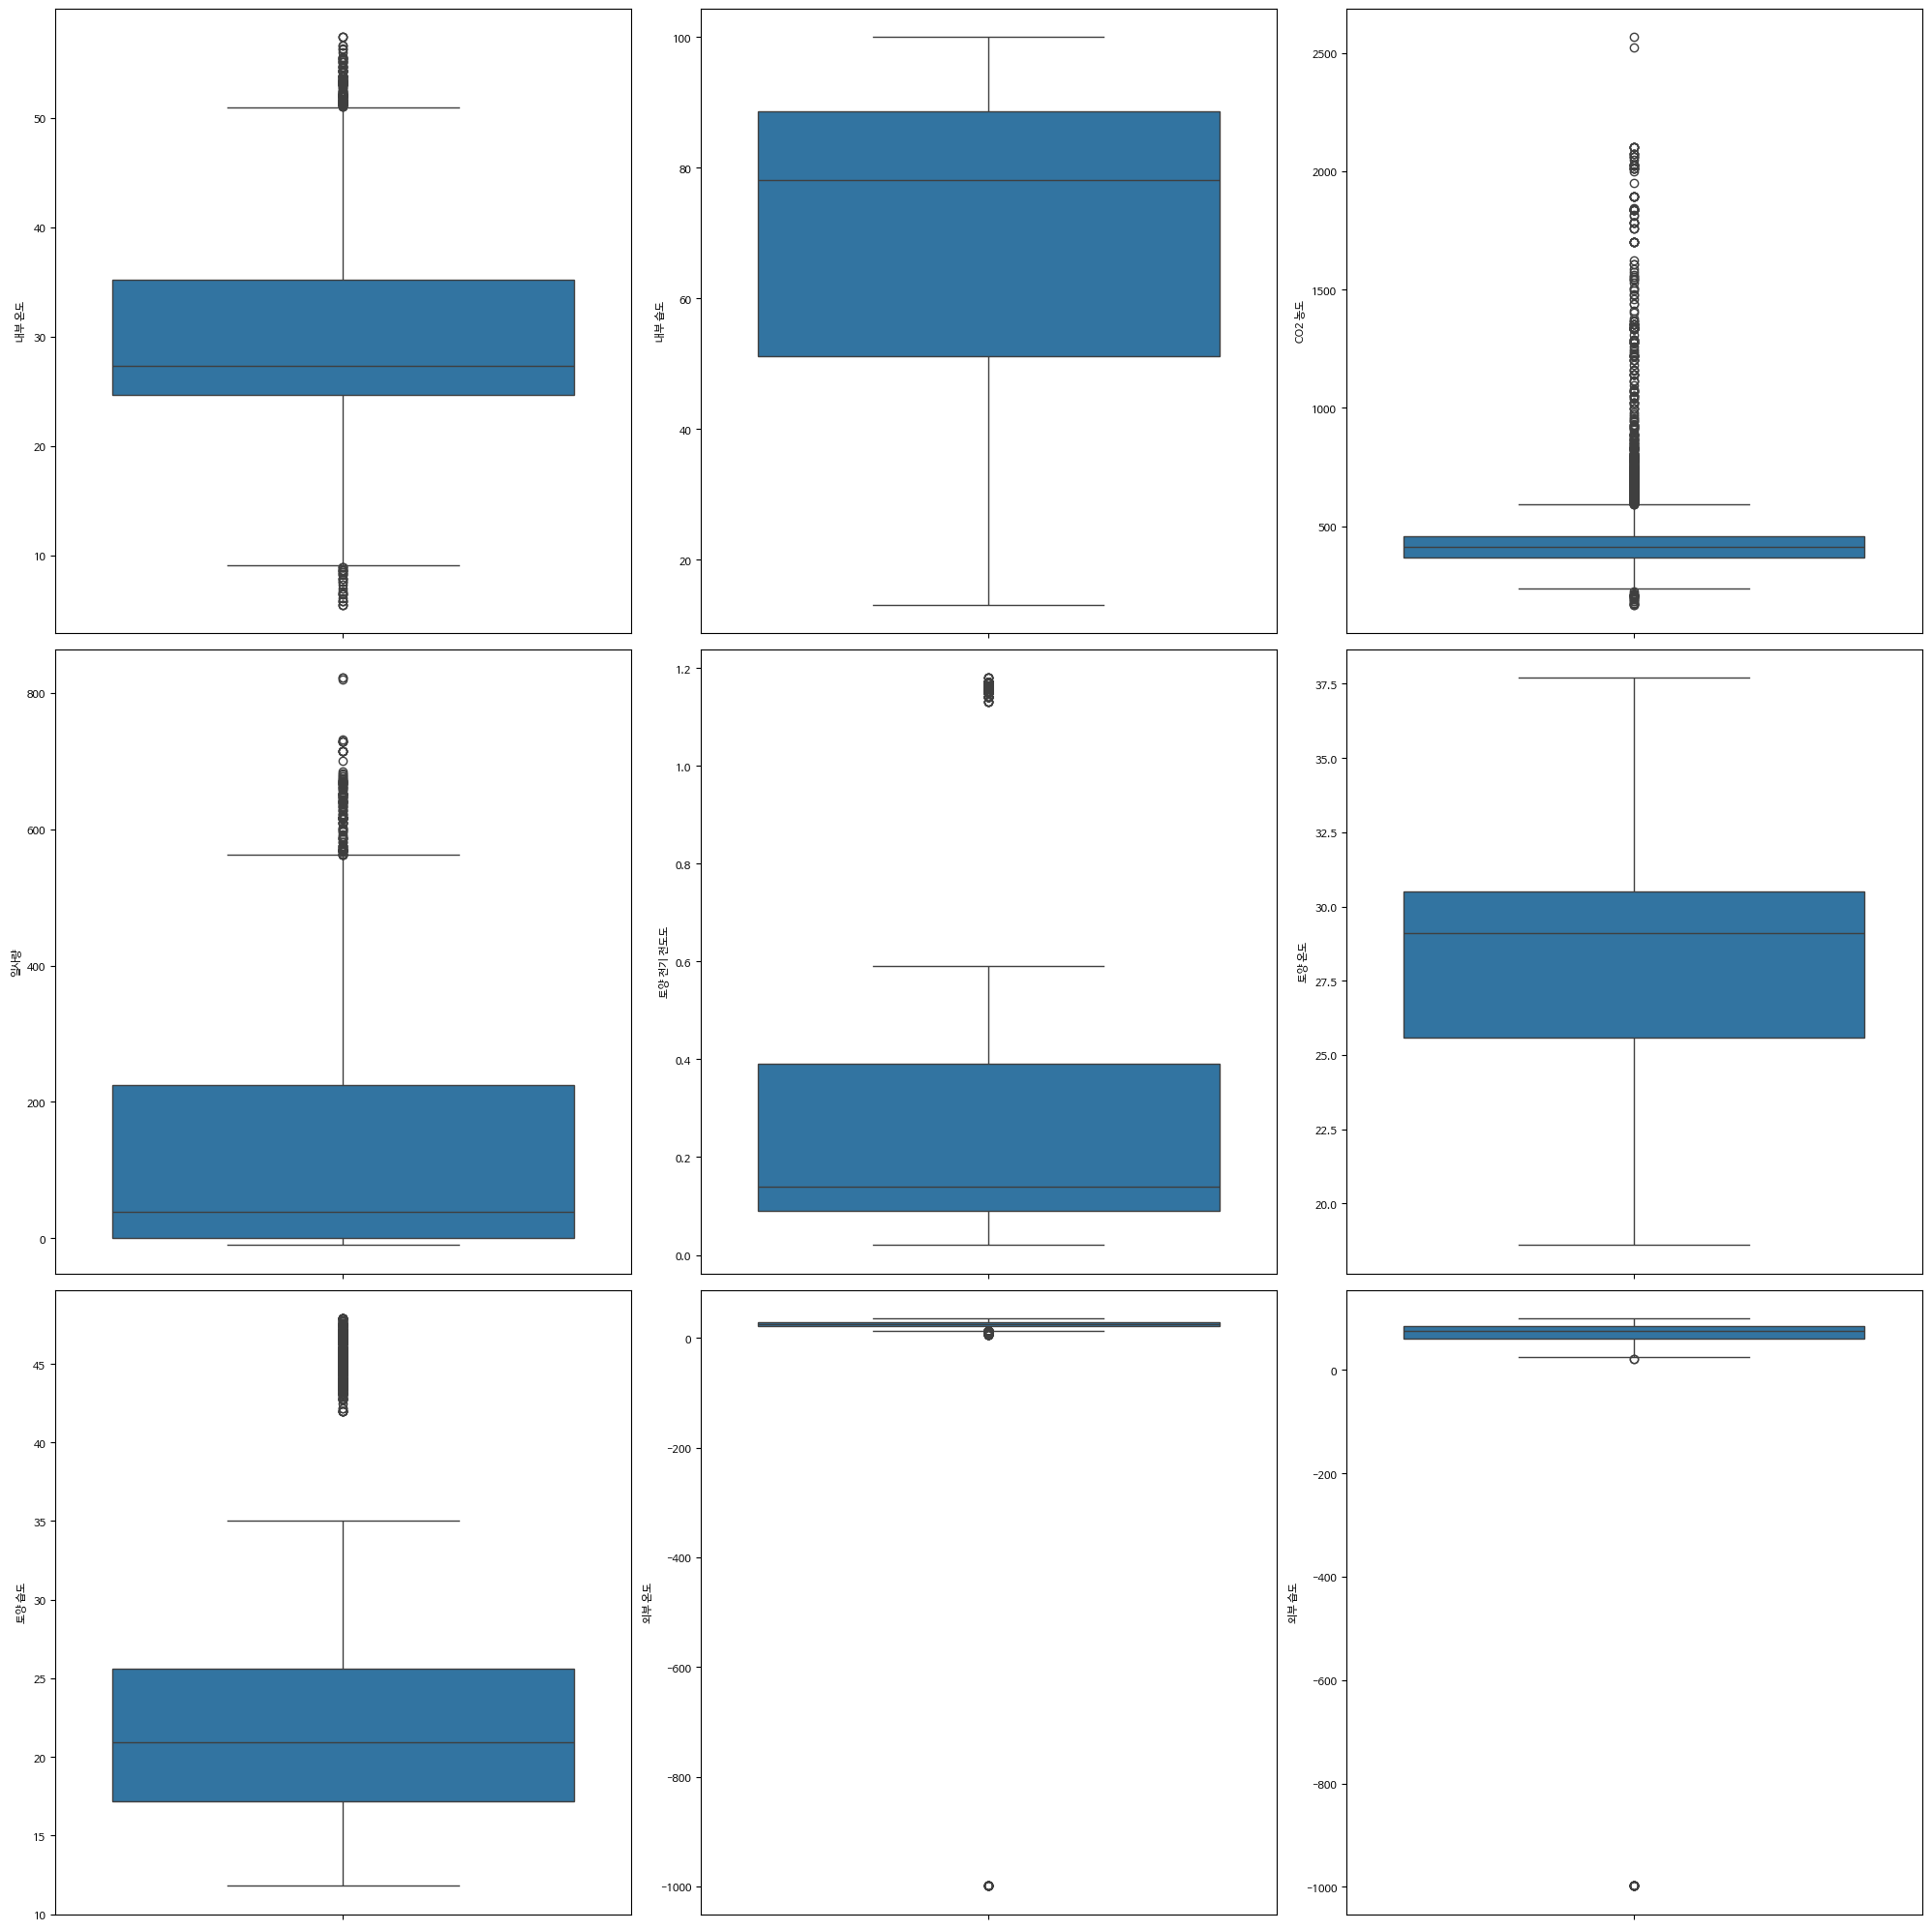

In [ ]:
# 박스플롯을 통해 이상치 쉽게 확인
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,20))
axes = axes.flatten()

for i, column in enumerate(numeric_cloumns):
  sns.boxplot(data=melon, y=column, ax=axes[i]) # x=column으로 하면 가로로 나옴

plt.tight_layout()
plt.show()

**수치형 데이터 분석:**
- 오른쪽으로 꼬리가 긴 분포(CO2 농도)
- 일사량이 0인 지점 빈도수가 많음
- 외부 온도, 외부 습도에 이상치가 존재

In [ ]:
melon[numeric_cloumns].describe().T

,count,mean,std,min,25%,50%,75%,max
내부 온도,7280.0,29.744409,8.786040,5.50,24.70,27.30,35.225,57.40
내부 습도,7280.0,70.145701,21.930567,13.10,51.10,78.10,88.600,100.00
CO2 농도,7280.0,451.483654,202.454348,169.00,370.00,411.00,459.000,2567.00
일사량,7280.0,122.190247,160.459740,-10.00,0.00,39.00,225.000,822.00
토양 전기 전도도,7280.0,0.310272,0.347421,0.02,0.09,0.14,0.390,1.18
토양 온도,7280.0,28.126442,3.284812,18.60,25.60,29.10,30.500,37.70
토양 습도,7280.0,23.377596,9.344153,11.80,17.20,20.90,25.600,47.90
외부 온도,7280.0,21.840179,56.452307,-999.00,22.30,26.00,28.000,36.00
외부 습도,7280.0,67.311538,60.798577,-998.00,60.00,75.00,84.000,100.00


In [ ]:
# describe 확인시 외부 온도에 -998이라는 이상치 값이 보임
melon['외부 온도'] != -999

,외부 온도
0,True
1,True
2,True
3,True
4,True
...,...
7275,True
7276,True
7277,True
7278,True


In [ ]:
(melon['외부 온도'] == -999).sum()

np.int64(22)

In [ ]:
(melon['외부 습도'] == -998).sum()

np.int64(22)

In [ ]:
# 위에서 확인해보니 외부온도가 잘못된 데이터는 외부습도도 잘못된 데이터임을 알 수 있었음
valid_data = melon[melon['외부 온도'] != -999 ]
valid_data['외부 온도'].mean(), valid_data['외부 습도'].mean() # 오른쪽으로 꼬리가 길면 mean()보다 median()을 하는게 좋음
# 외부 온도와 외부 습도의 이상치를 대표값(정상인 데이터들의 평균)으로 대체하자.

(np.float64(24.93448608432075), np.float64(70.5406448057316))

In [ ]:
# todo 22개의 이상치를 대표값(정상인 데이터들의 평균)으로 대체하기
melon['외부 온도'] = melon['외부 온도'].replace(-999, melon['외부 온도'][melon['외부 온도'] != -999].mean())
melon['외부 습도'] = melon['외부 습도'].replace(-998, melon['외부 습도'][melon['외부 습도'] != -999].mean())

In [ ]:
# 강사님 풀이
melon.loc[melon['외부 온도'] == -999, '외부 온도'] = valid_data['외부 온도'].mean()
melon.loc[melon['외부 습도'] == -998, '외부 습도'] = valid_data['외부 습도'].mean()

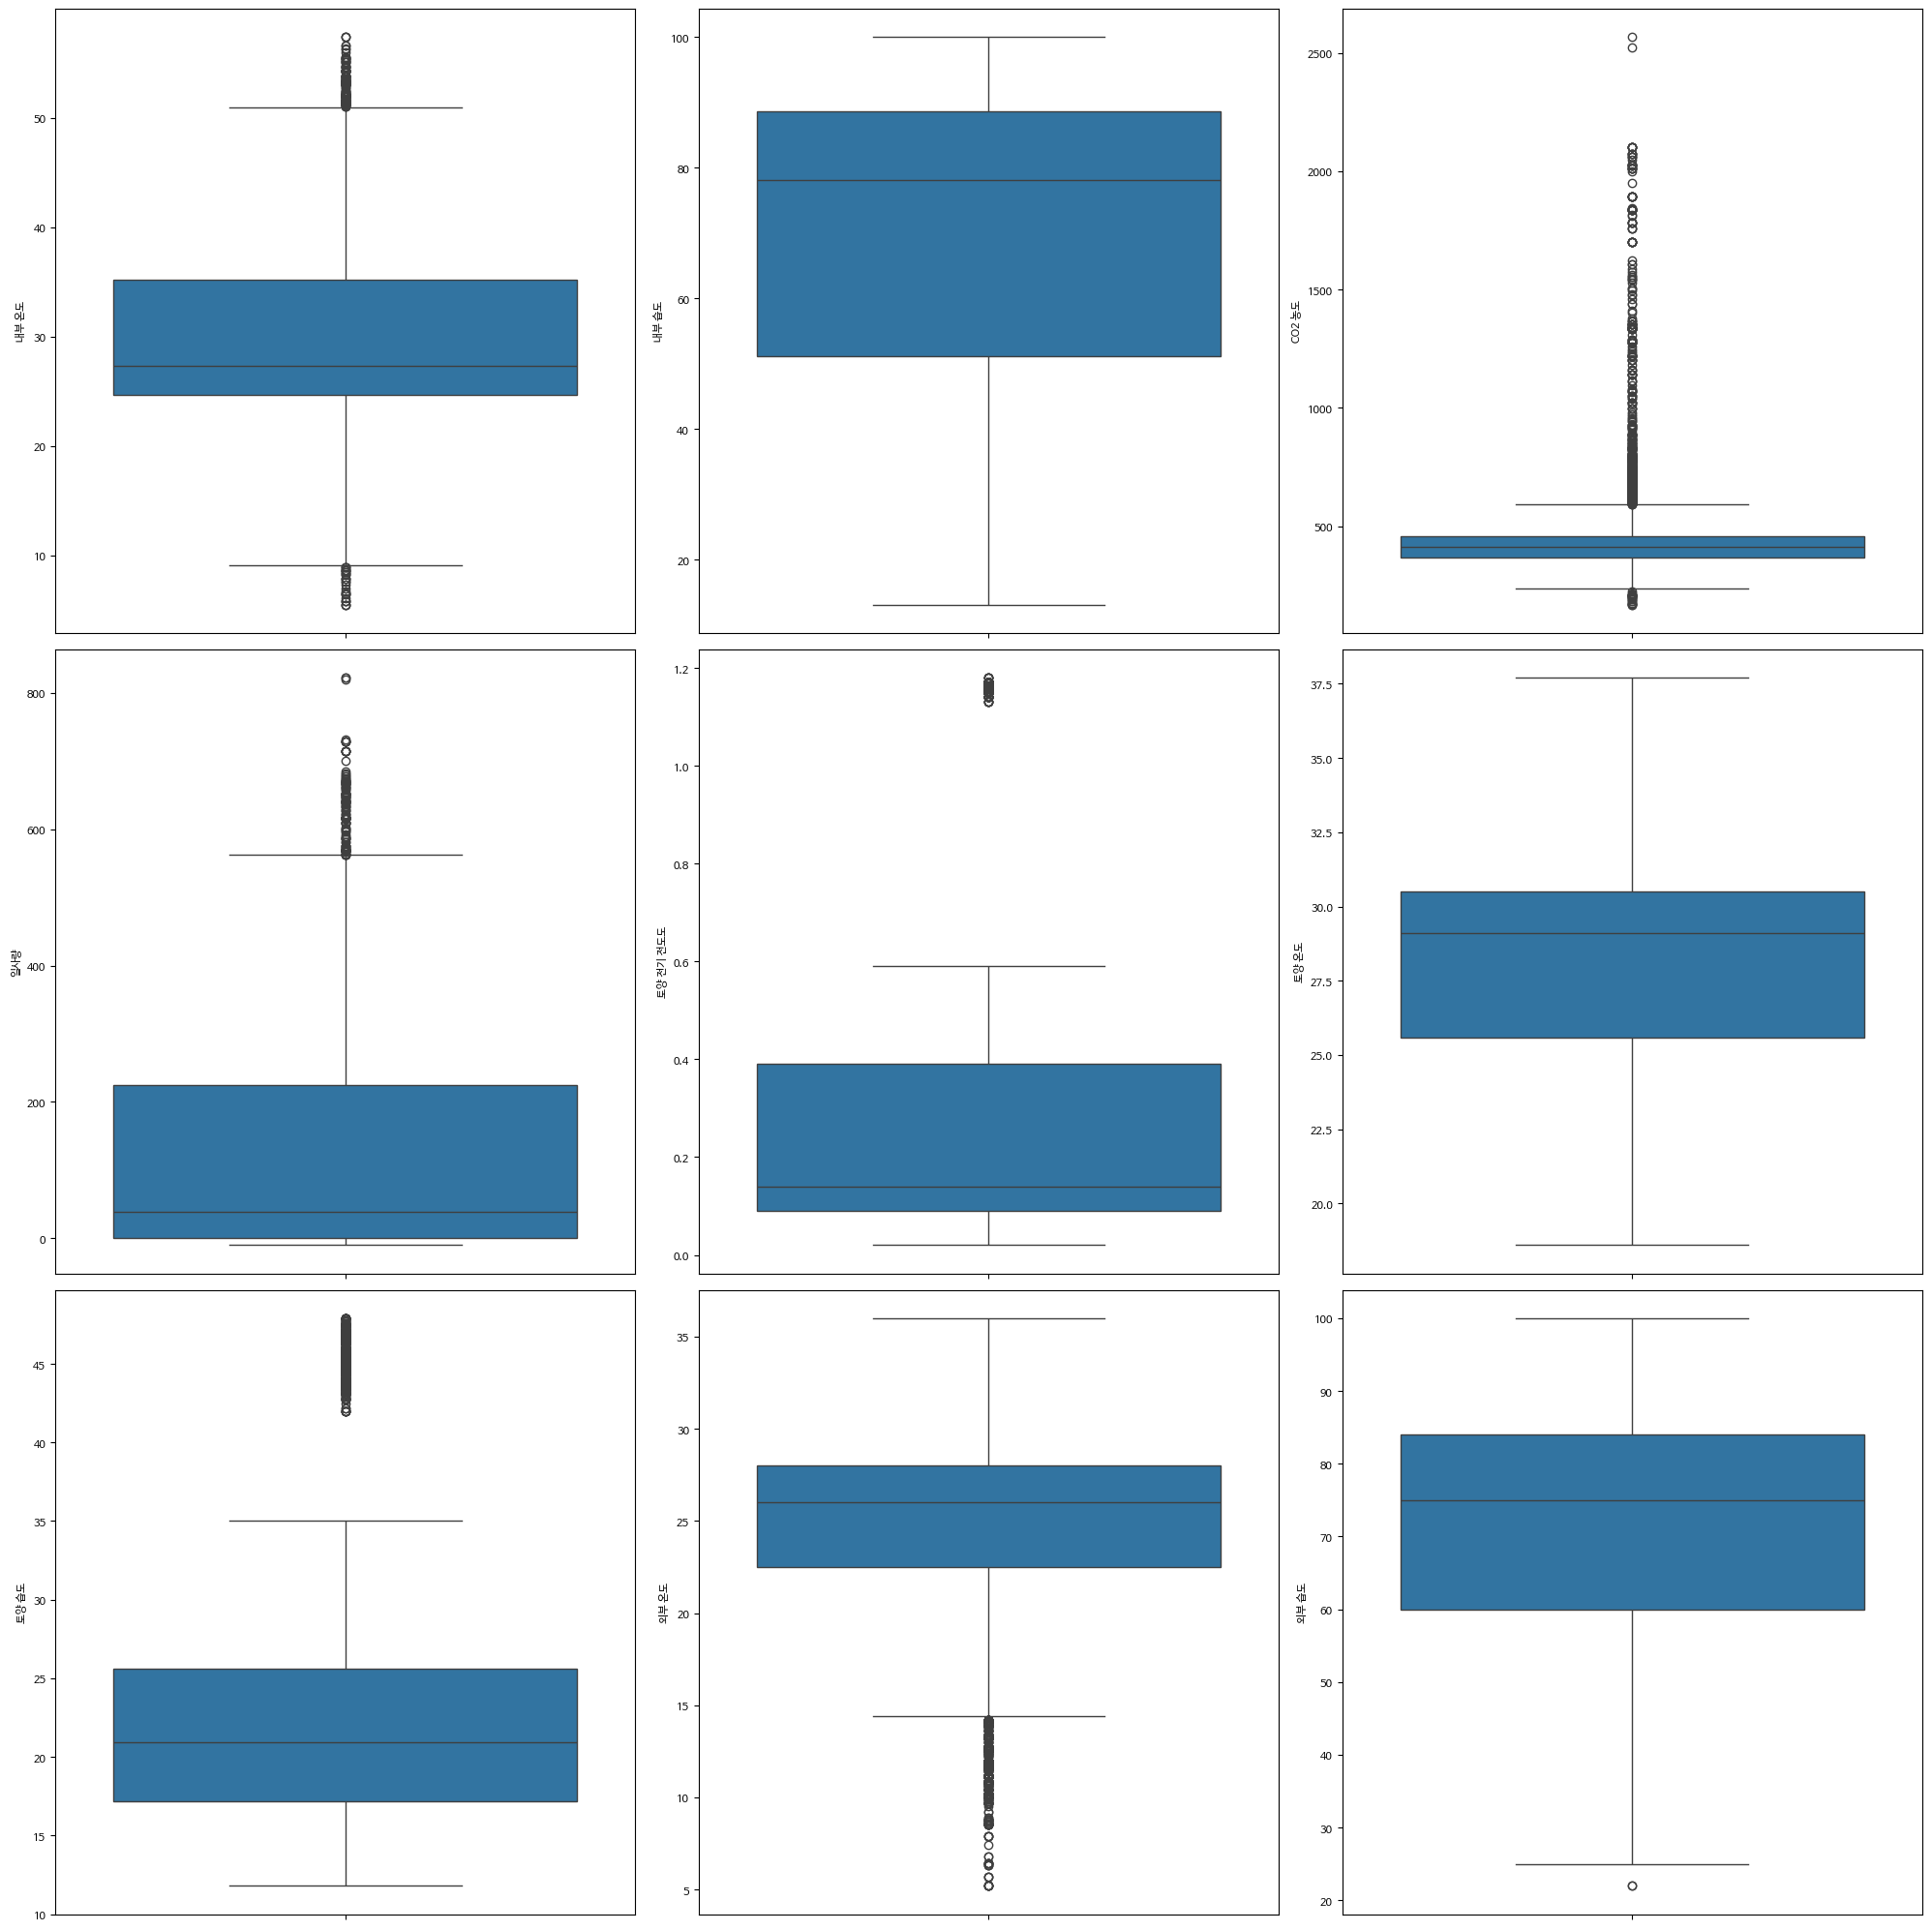

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,20))
axes = axes.flatten()

for i, column in enumerate(numeric_cloumns):
  sns.boxplot(data=melon, y=column, ax=axes[i])

plt.tight_layout()
plt.show()

### 데이터 관계 시각화

**산점도**

In [ ]:
numeric_cloumns + ['병해 유형']

['내부 온도',
 '내부 습도',
 'CO2 농도',
 '일사량',
 '토양 전기 전도도',
 '토양 온도',
 '토양 습도',
 '외부 온도',
 '외부 습도',
 '병해 유형']

In [ ]:
# sns.pairplot(melon[numeric_cloumns + ['병해 유형']], hue='병해 유형', # heu 카테고리(범주형) 변수에 따라 색상을 다르게 표현
#              plot_kws= {'alpha': 0.3}) # 키워드 투명도
# plt.show()

**산점도 분석**
- 토양습도가 높은 구간에 흰가루병 클래스가 분리되어 있음

**상관 계수**

In [ ]:
corr = melon[numeric_cloumns].corr()
corr

,내부 온도,내부 습도,CO2 농도,일사량,토양 전기 전도도,토양 온도,토양 습도,외부 온도,외부 습도
내부 온도,1.000000,-0.821499,-0.397189,0.840303,-0.298599,0.270350,-0.248908,0.401592,-0.223627
내부 습도,-0.821499,1.000000,0.383904,-0.856321,-0.113343,0.035521,-0.127414,-0.017653,0.302710
CO2 농도,-0.397189,0.383904,1.000000,-0.291081,0.071078,-0.195495,0.041607,-0.285762,0.277187
일사량,0.840303,-0.856321,-0.291081,1.000000,-0.008751,-0.081110,0.012296,0.079717,-0.251394
토양 전기 전도도,-0.298599,-0.113343,0.071078,-0.008751,1.000000,-0.478135,0.965389,-0.596677,0.030258
토양 온도,0.270350,0.035521,-0.195495,-0.081110,-0.478135,1.000000,-0.515854,0.572872,0.053353
토양 습도,-0.248908,-0.127414,0.041607,0.012296,0.965389,-0.515854,1.000000,-0.534468,0.008565
외부 온도,0.401592,-0.017653,-0.285762,0.079717,-0.596677,0.572872,-0.534468,1.000000,-0.488550
외부 습도,-0.223627,0.302710,0.277187,-0.251394,0.030258,0.053353,0.008565,-0.488550,1.000000


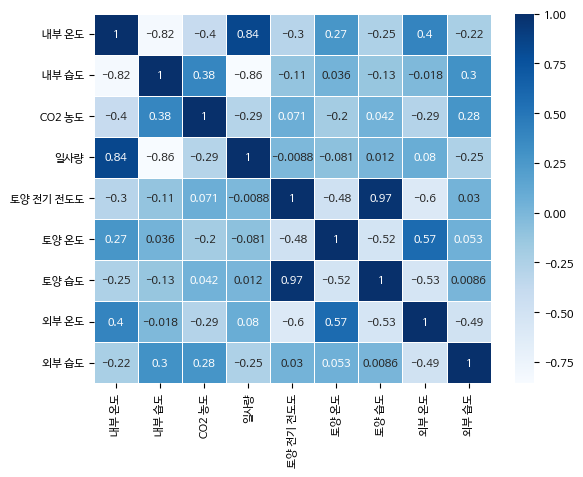

In [ ]:
sns.heatmap(corr, cmap='Blues', annot=True, linewidth=0.5)
plt.show()

**데이터 상관관계 분석**
- 내부온도와 일사량은 양의 상관관계(0.84)
- 토양 전기 전도도와 토양습도는 강한 양의 상관관계(0.97)
- 내부 습도와 내부 온도는 음의 상관 관계(-0.82)
- 내부 습도와 일사량은 음의 상관 관계(-0.86)

### 병해 유형(타깃)별 환경 특성

In [ ]:
numeric_cloumns

['내부 온도',
 '내부 습도',
 'CO2 농도',
 '일사량',
 '토양 전기 전도도',
 '토양 온도',
 '토양 습도',
 '외부 온도',
 '외부 습도']

In [ ]:
env_factor1 = numeric_cloumns[:4]
env_factor2 = numeric_cloumns[4:]
env_factor = env_factor1 + env_factor2

In [ ]:
melon[env_factor].describe().T

,count,mean,std,min,25%,50%,75%,max
내부 온도,7280.0,29.744409,8.786040,5.50,24.70,27.30,35.225,57.40
내부 습도,7280.0,70.145701,21.930567,13.10,51.10,78.10,88.600,100.00
CO2 농도,7280.0,451.483654,202.454348,169.00,370.00,411.00,459.000,2567.00
일사량,7280.0,122.190247,160.459740,-10.00,0.00,39.00,225.000,822.00
토양 전기 전도도,7280.0,0.310272,0.347421,0.02,0.09,0.14,0.390,1.18
토양 온도,7280.0,28.126442,3.284812,18.60,25.60,29.10,30.500,37.70
토양 습도,7280.0,23.377596,9.344153,11.80,17.20,20.90,25.600,47.90
외부 온도,7280.0,24.934486,5.256953,5.20,22.50,26.00,28.000,36.00
외부 습도,7280.0,70.530887,16.000675,22.00,60.00,75.00,84.000,100.00


numeric_cloumns 데이터의 종류가 9개나 있는데 어떻게 비교를 하면 좋을까??

## (1) 병해 유형별 env_factor1의 환경요인 평균값과 분포

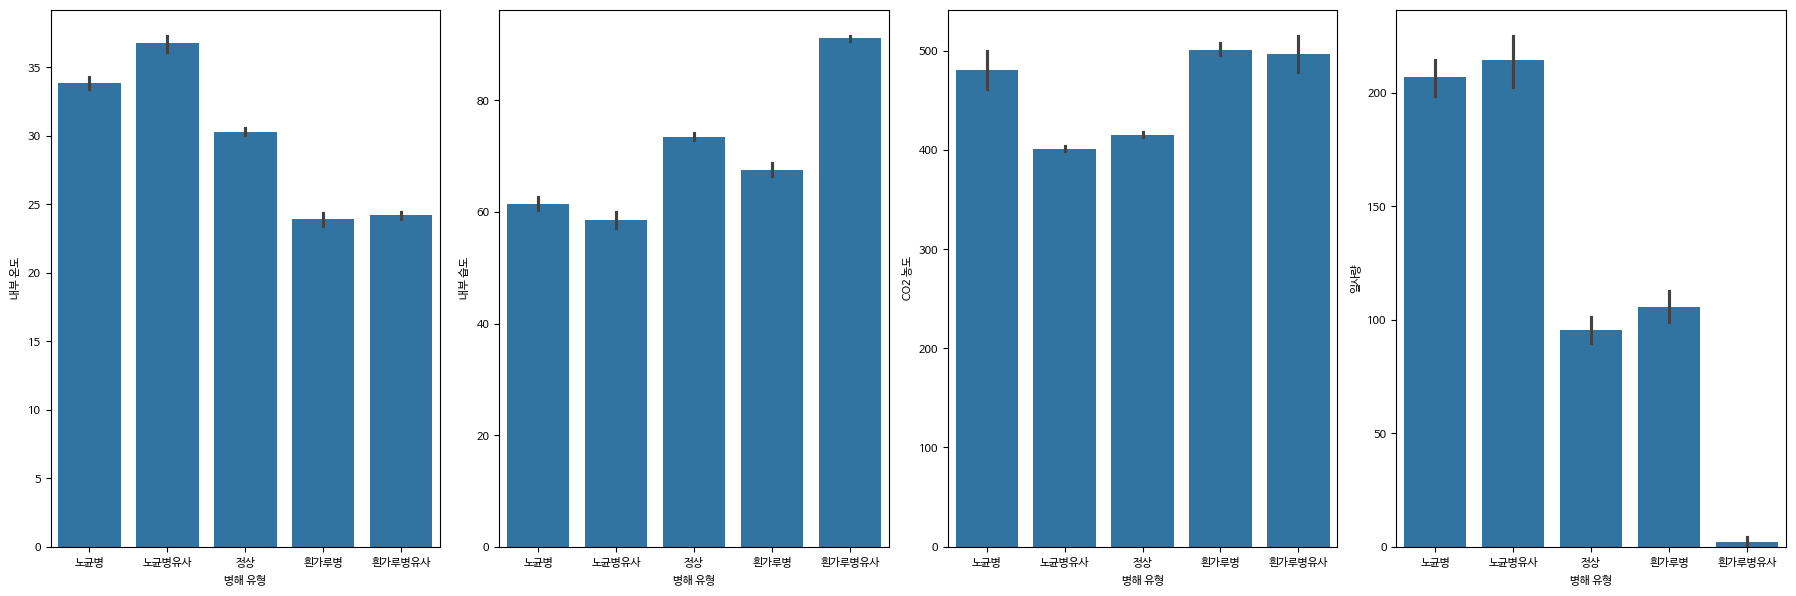

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18,6))

for i, column in enumerate(env_factor1):
  sns.barplot(data=melon, x='병해 유형', y=column, ax=axes[i])

plt.tight_layout()
plt.show()

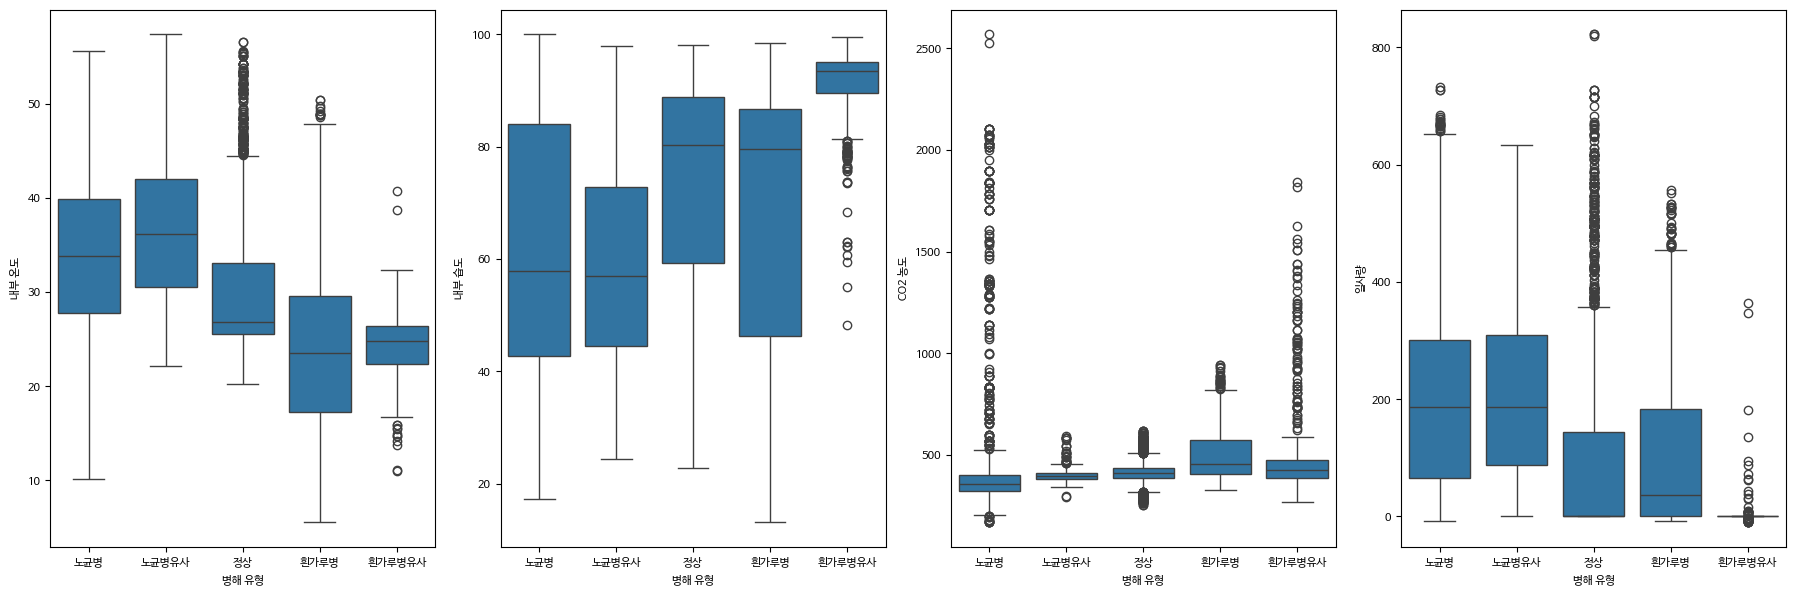

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18,6))

for i, column in enumerate(env_factor1):
  sns.boxplot(data=melon, x='병해 유형', y=column, ax=axes[i])

plt.tight_layout()
plt.show()

**env_factor1 특성이 병해에 미치는 영향 분석**
- 흰가루병의 일사량이 매우 작음
- 흰가루병과 흰가루병 유사의 내부 온도가 다소 낮음

## (2) 병해 유형별 env_factor2의 환경요인 평균값과 분포

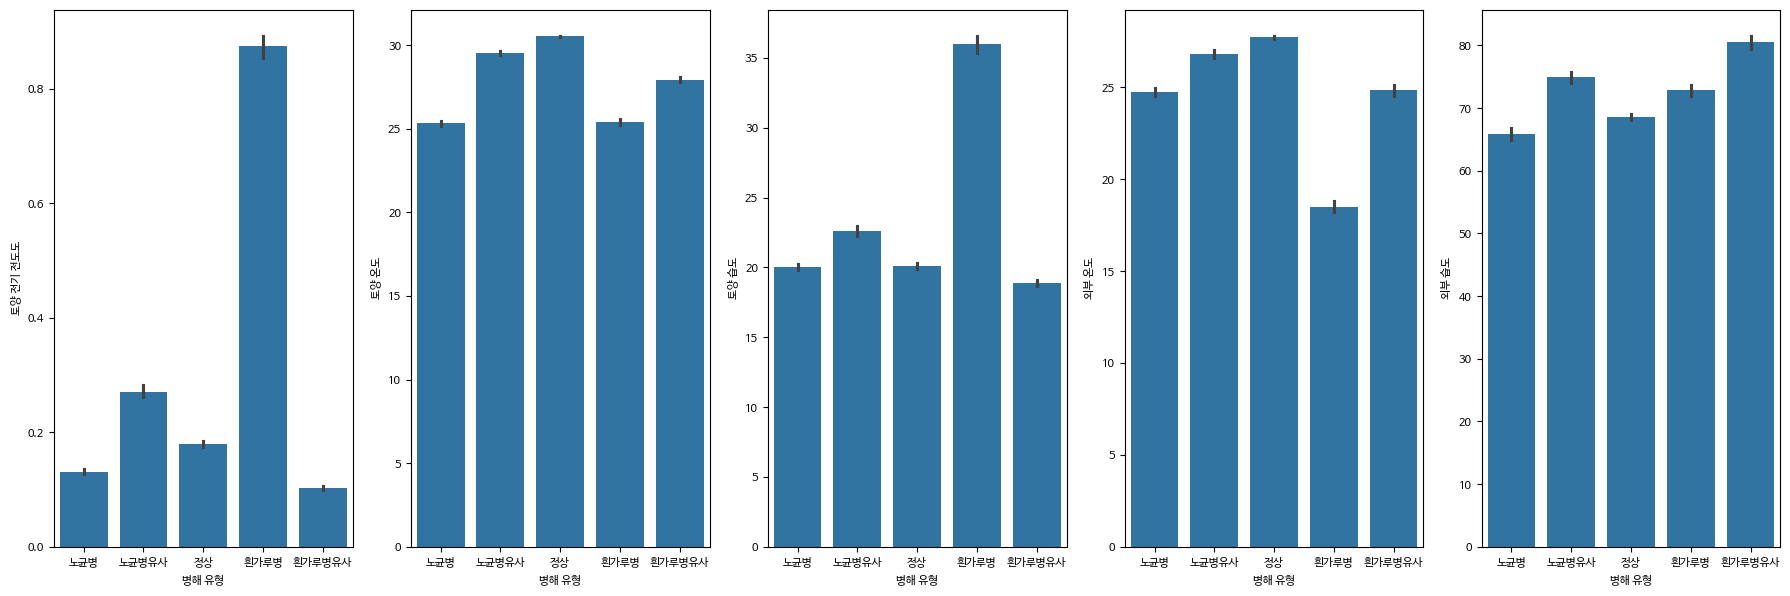

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(18,6))

for i, column in enumerate(env_factor2):
  sns.barplot(data=melon, x='병해 유형', y=column, ax=axes[i])

plt.tight_layout()
plt.show()

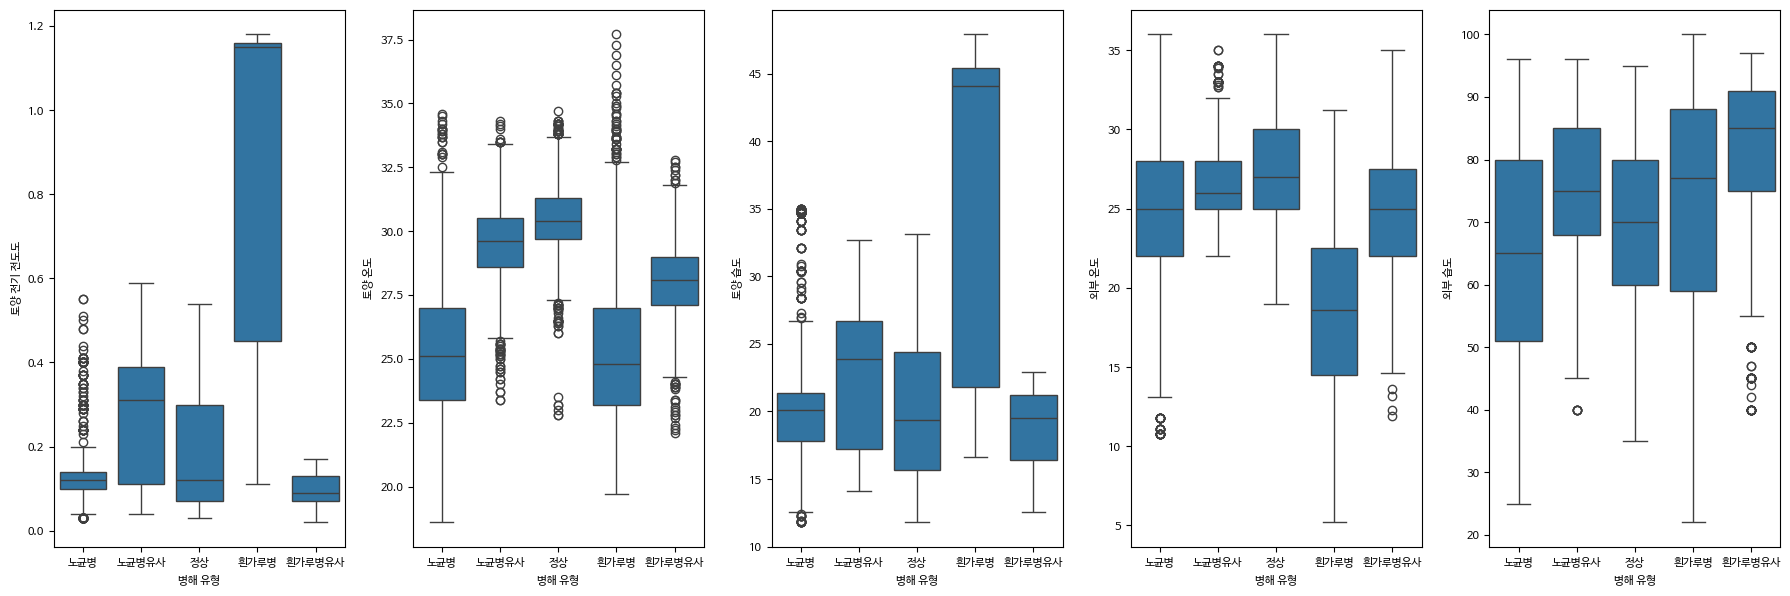

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(18,6))

for i, column in enumerate(env_factor2):
  sns.boxplot(data=melon, x='병해 유형', y=column, ax=axes[i])

plt.tight_layout()
plt.show()

**env_factor2 특성이 병해에 미치는 영향 분석**
- 흰가루병의 경우 토양 전기 전도도와 토양 습도가 높음
- 흰가루병의 외부 온도가 다소 낮음

#### (3) 강수 유무에 따른 병해 유형
- 강수 유무에 따른 병해 유형별 빈도의 차이 집계할때 crosstab 함수 사용

In [ ]:
# pd.crosstab(행(강수 유무), 열(병해 유형))
disease_cnt = pd.crosstab(melon['강수 유무'], melon['병해 유형'])
disease_cnt # 비오는날 맑은 날이 병에 관계가 있을까? 근데 식물은 맑은 날 크는거자나

병해 유형,노균병,노균병유사,정상,흰가루병,흰가루병유사
강수 유무,,,,,
맑음,1414,629,3013,1417,622
비,46,31,27,43,38


In [ ]:
disease_cnt.sum(axis=1)

,0
강수 유무,
맑음,7095
비,185


In [ ]:
disease_rate = disease_cnt.div(disease_cnt.sum(axis=1), axis=0) # 각 행의 모든 열 값을 그 행의 합계로 나누는 것
disease_rate

병해 유형,노균병,노균병유사,정상,흰가루병,흰가루병유사
강수 유무,,,,,
맑음,0.199295,0.088654,0.424665,0.199718,0.087667
비,0.248649,0.167568,0.145946,0.232432,0.205405


<Axes: xlabel='병해 유형', ylabel='강수 유무'>

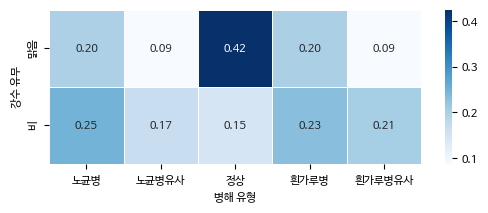

In [ ]:
plt.figure(figsize=(6, 2))
sns.heatmap(disease_rate, annot=True, fmt='.2f', cmap='Blues', linewidth=0.5)

**강수 유무에 데이터 분석**
- 강수 유무에 따른 병해 유형의 빈도수가 다름
- 맑은날에 정상유형이 많았음

#### (4) 시간 특성

**생육 단계에 따른 병해 유형**
- 생육 단계에 따른 병해 유형별 빈도의 차이 집계할때 crosstab 함수 사용

In [ ]:
# pd.crosstab(행(강수 유무), 열(병해 유형))
disease_cnt = pd.crosstab(melon['생육 단계'], melon['병해 유형'])
disease_cnt

병해 유형,노균병,노균병유사,정상,흰가루병,흰가루병유사
생육 단계,,,,,
수확,954,0,0,1446,22
정식,226,92,2950,0,36
착과,280,568,90,14,602


In [ ]:
disease_rate = disease_cnt.div(disease_cnt.sum(axis=1), axis=0)
disease_rate

병해 유형,노균병,노균병유사,정상,흰가루병,흰가루병유사
생육 단계,,,,,
수확,0.393889,0.000000,0.000000,0.597027,0.009083
정식,0.068402,0.027845,0.892857,0.000000,0.010896
착과,0.180180,0.365508,0.057915,0.009009,0.387387


<Axes: xlabel='병해 유형', ylabel='생육 단계'>

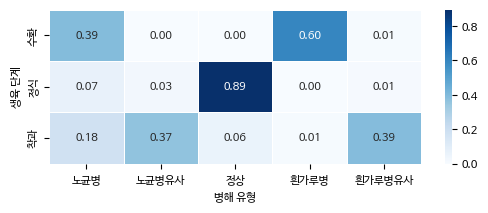

In [ ]:
plt.figure(figsize=(6, 2))
sns.heatmap(disease_rate, annot=True, fmt='.2f', cmap='Blues', linewidth=0.5)

**생육 단계에 데이터 분석**
- 생육 단계에 따른 병해 유형의 빈도수가 다름
- 착과 단계에 노균병 유사와 흰가루병 유사가 많았음
- 정식 단계에 정상 유형이 많았음
- 수확 단계에 흰가루병이 많았으며 노균병도 일정 비율 가짐

**데이터 수신시간에 따른 병해 유형**

In [ ]:
# todo

In [ ]:
# 날짜 형식으로 변환
melon['데이터 수신시간'] = pd.to_datetime(melon['데이터 수신시간'])

# 수신일자를 월 단위로 추출
melon['수신월'] = melon['데이터 수신시간'].dt.to_period('M').astype(str)
# 또는 주 단위: .dt.to_period('W').astype(str)

# 월별 병해 비율 테이블 생성
disease_rate = pd.crosstab(melon['수신월'], melon['병해 유형'], normalize='index')
disease_rate

병해 유형,노균병,노균병유사,정상,흰가루병,흰가루병유사
수신월,,,,,
2022-06,0.031399,0.005461,0.961775,0.000000,0.001365
2022-07,0.088350,0.171503,0.683846,0.000000,0.056301
2022-08,0.084112,0.299065,0.060748,0.021028,0.535047
2022-09,0.647327,0.000000,0.000000,0.312856,0.039818
2022-10,0.000000,0.000000,0.000000,1.000000,0.000000


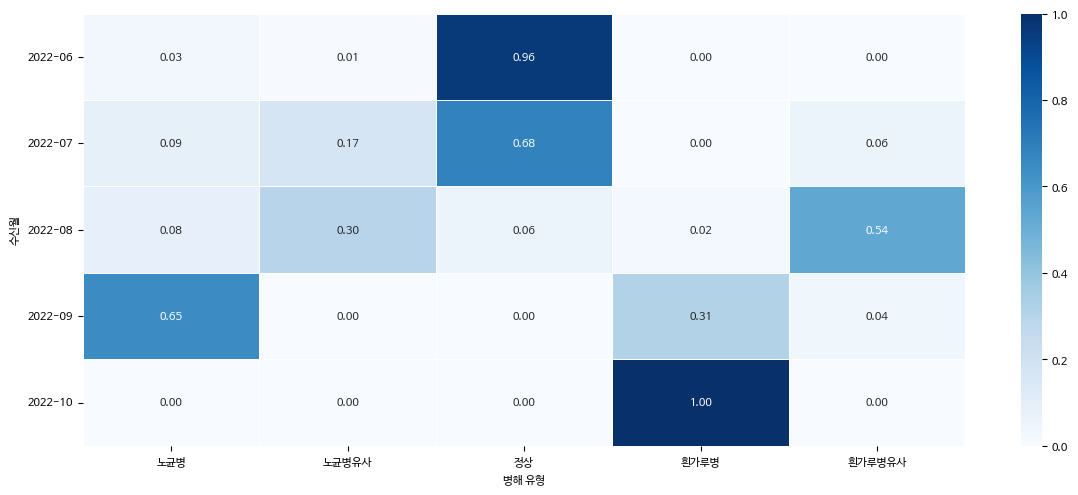

In [ ]:
plt.figure(figsize=(12, 5))
sns.heatmap(disease_rate, annot=True, fmt='.2f', cmap='Blues', linewidth=0.5)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# 강사님 풀이

In [ ]:
melon['데이터 수신시간'] = pd.to_datetime(melon['데이터 수신시간'])
melon['데이터 수신시간']

,데이터 수신시간
0,2022-07-05 12:00:00
1,2022-07-05 12:30:00
2,2022-07-06 06:00:00
3,2022-07-06 06:30:00
4,2022-07-07 15:00:00
...,...
7275,2022-08-08 03:00:00
7276,2022-08-09 03:30:00
7277,2022-08-09 04:00:00
7278,2022-08-09 22:30:00


In [ ]:
# 월별, 시간별 주차 별 등 파생 변수 생성
# 시간에 따른 병해 유형이 어떤 관련이 있는지 살펴보기
melon['월'] = melon['데이터 수신시간'].dt.month
melon['시간'] = melon['데이터 수신시간'].dt.hour
melon['연중일수'] = melon['데이터 수신시간'].dt.dayofyear
melon['주차'] = melon['데이터 수신시간'].dt.isocalendar().week

In [ ]:
time_factors = ['월', '시간', '연중일수', '주차']

**월별 병해 유형 빈도수**

In [ ]:
melon.groupby(['월', '병해 유형']).size()

월   병해 유형 
6   노균병         46
    노균병유사        8
    정상        1409
    흰가루병유사       2
7   노균병        204
    노균병유사      396
    정상        1579
    흰가루병유사     130
8   노균병         72
    노균병유사      256
    정상          52
    흰가루병        18
    흰가루병유사     458
9   노균병       1138
    흰가루병       550
    흰가루병유사      70
10  흰가루병       892
dtype: int64

In [ ]:
# 시각화 할 수 있는 형태로 만들기
melon.groupby(['월', '병해 유형']).size().reset_index(name='count')

,월,병해 유형,count
0,6,노균병,46
1,6,노균병유사,8
2,6,정상,1409
3,6,흰가루병유사,2
4,7,노균병,204
5,7,노균병유사,396
6,7,정상,1579
7,7,흰가루병유사,130
8,8,노균병,72
9,8,노균병유사,256


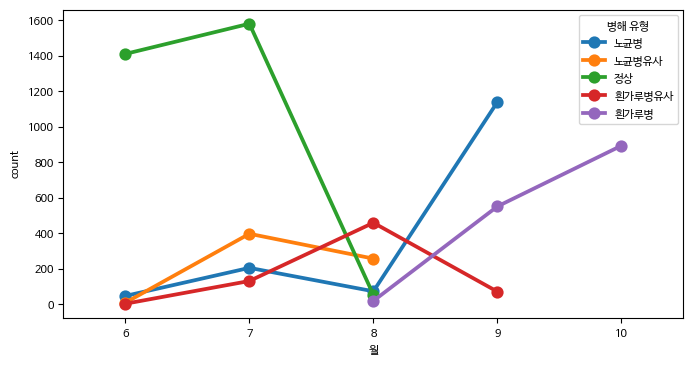

In [ ]:
plt.figure(figsize=(8, 4))
monthly_counts = melon.groupby(['월', '병해 유형']).size().reset_index(name='count')
sns.pointplot(data=monthly_counts, x='월', y='count', hue='병해 유형')
plt.show()

**시간별 병해 유형 빈도수**

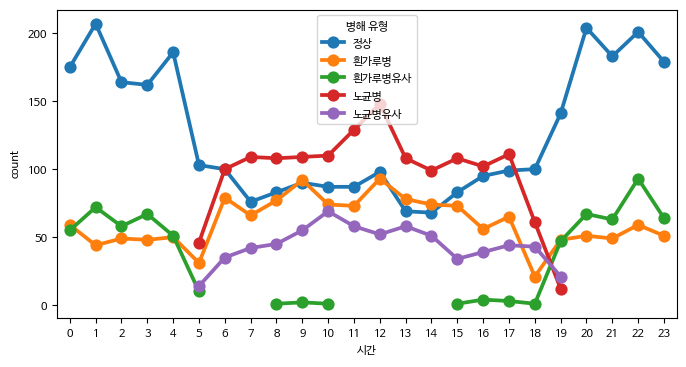

In [ ]:
plt.figure(figsize=(8, 4))
hourly_counts = melon.groupby(['시간', '병해 유형']).size().reset_index(name='count')
sns.pointplot(data=hourly_counts, x='시간', y='count', hue='병해 유형')
plt.show()

**연중 일수별 병해 유형 빈도수**

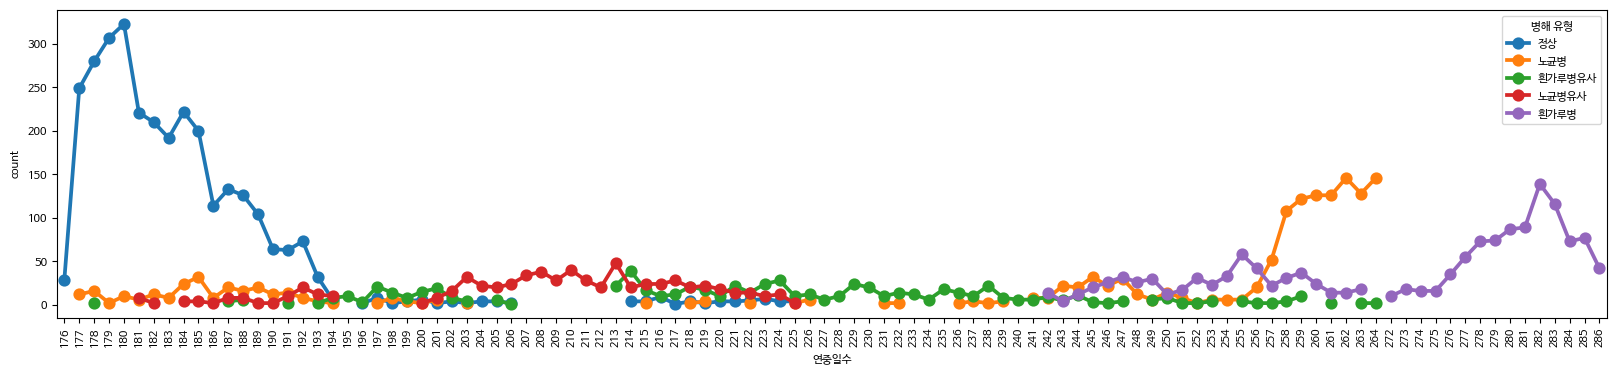

In [ ]:
plt.figure(figsize=(20, 4))
daily_counts = melon.groupby(['연중일수', '병해 유형']).size().reset_index(name='count')
sns.pointplot(data=daily_counts, x='연중일수', y='count', hue='병해 유형')
plt.xticks(rotation=90)
plt.show()

**주차별 병해 유형 빈도수**

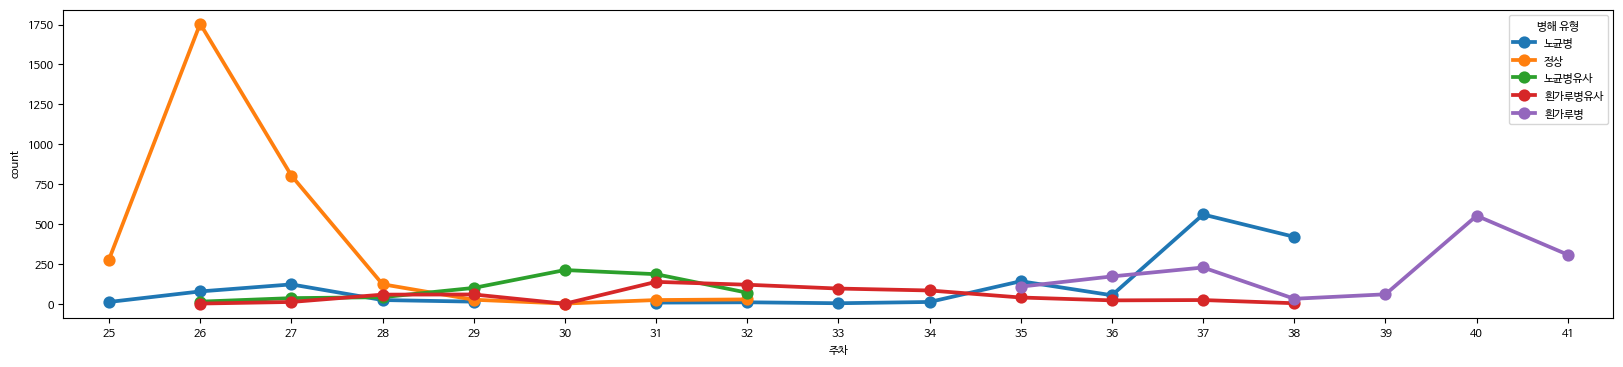

In [ ]:
plt.figure(figsize=(20, 4))
weekly_counts = melon.groupby(['주차', '병해 유형']).size().reset_index(name='count')
sns.pointplot(data=weekly_counts, x='주차', y='count', hue='병해 유형')
plt.show()

In [ ]:
time_corr = melon[time_factors].corr()
time_corr

,월,시간,연중일수,주차
월,1.000000,-0.012452,0.971926,0.968593
시간,-0.012452,1.000000,-0.014435,-0.013443
연중일수,0.971926,-0.014435,1.000000,0.998542
주차,0.968593,-0.013443,0.998542,1.000000


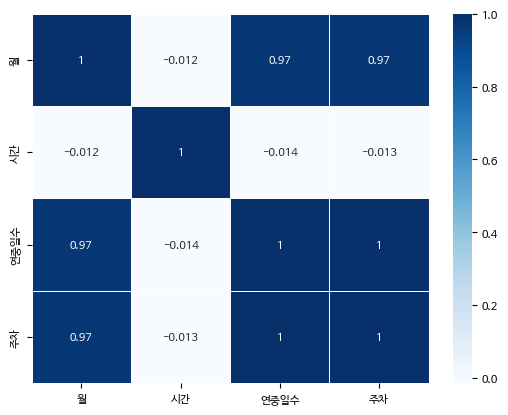

In [ ]:
sns.heatmap(time_corr, cmap='Blues', annot=True, linewidth=0.5)
plt.show()

**시간 특성 분석 결과**

- 시간 특성(월, 연중일수, 주차, 시간대)에 따른 병해 유형의 빈도수에 차이가 남
- 그러나 개별 시간 특성이 유사한 정보를 담고 있어서 상관 관계가 높음

## 4. 데이터 전처리

In [ ]:
melon = pd.read_csv(rootdir+'melon_environment.csv',sep=',')

In [ ]:
melon.shape

(7280, 13)

**특성 데이터(X)와 정답 데이터(y)가 분리**

In [ ]:
X = melon.drop(['병해 유형', '데이터 수신시간'], axis=1)
y = melon['병해 유형']

In [ ]:
X.columns

Index(['생육 단계', '내부 온도', '내부 습도', 'CO2 농도', '일사량', '토양 전기 전도도', '토양 온도',
       '토양 습도', '강수 유무', '외부 온도', '외부 습도'],
      dtype='object')

In [ ]:
X_num = X.drop(['생육 단계', '강수 유무'], axis=1)
X_cat = X[['강수 유무', '생육 단계']]
# X_time =  시간 정보도 넣어서 해보기

X_num.shape, X_cat.shape

((7280, 9), (7280, 2))

### 4.1 데이터 전처리(1) - 결손값 처리

**결손값(Null/NaN) 처리 방법**

- 옵션1 : 해당 구역 제거
- 옵션2 : 전체 특성 삭제
- 옵션3 : 어떤 값으로 대체(0, 평균, 중간값 등)

In [ ]:
valid_data = X_num[X_num['외부 온도'] != -999 ]
valid_data = X_num[X_num['외부 습도'] != -998 ]

melon.loc[melon['외부 온도'] == -999, '외부 온도'] = valid_data['외부 온도'].mean()
melon.loc[melon['외부 습도'] == -998, '외부 습도'] = valid_data['외부 습도'].mean()

**결손값 처리:** 일사량, min()값으로 대체

In [ ]:
(X_num['일사량'] < 0).sum()

np.int64(33)

In [ ]:
# 데이터셋에서 일사량이 0보다 큰 값들 중에 가장 작은값
min_value = (X_num[X_num['일사량'] >= 0]['일사량']).min()
X_num.loc[X_num['일사량'] < 0, '일사량'] = min_value

In [ ]:
(X_num['일사량'] < 0).sum()

np.int64(0)

### 4.2 데이터 전처리(2) - 데이터 인코딩
- 데이터 인코딩을 하는 이유는 머신러닝에서 수치값만 기대하기 때문

#### (1) 레이블 인코딩

In [ ]:
y_enc, y_category = pd.factorize(y)

In [ ]:
y_enc

array([0, 0, 0, ..., 4, 4, 4])

In [ ]:
y_category

Index(['노균병', '노균병유사', '정상', '흰가루병', '흰가루병유사'], dtype='object')

#### (2) 원핫 인코딩
숫자의 크기가 모델 훈련과정에서 잘못된 영향을 줄 수 있으므로 원핫 인코딩

In [ ]:
X_cat_oh = pd.get_dummies(X_cat) # 범주형을 True, False로 바꿔줌
X_cat_oh

,강수 유무_맑음,강수 유무_비,생육 단계_수확,생육 단계_정식,생육 단계_착과
0,True,False,False,True,False
1,True,False,False,True,False
2,True,False,False,True,False
3,True,False,False,True,False
4,True,False,False,True,False
...,...,...,...,...,...
7275,True,False,False,False,True
7276,True,False,False,False,True
7277,True,False,False,False,True
7278,True,False,False,False,True


### 4.3 데이터 전처리(3) - 특성 스케일링
- 표준화 (Z score Standardize) : 평균 0, 표준편차 1
- 정규화 (Min Max Scaling) : 0~1 사이로 정규화 (참고 : 특잇값에 영향을 받음)
- 로그 스케일링 : 데이터의 분포가 왜곡되어 있을때 주로 사용

**표준화 또는 정규화**

In [ ]:
# pandas -> from sklearn.preprocessing import StandardScaler와 같
def minmax_normalize(arr):
  return (arr - arr.min())/(arr.max()-arr.min())

def zscore_standardize(arr):
  return (arr - arr.mean())/arr.std()

In [ ]:
X_num_std = X_num.apply(zscore_standardize) # zscore 일괄 적용.apply

In [ ]:
X_num_std.mean() # 평균0, 표준편차 1로 바뀌었는지 확인

,0
내부 온도,2.810938e-16
내부 습도,5.153387e-16
CO2 농도,-4.294489e-17
일사량,-3.123265e-17
토양 전기 전도도,6.246530e-17
토양 온도,-1.249306e-16
토양 습도,-2.342449e-16
외부 온도,1.561632e-17
외부 습도,5.856121e-18


In [ ]:
X_num_std.std()

,0
내부 온도,1.0
내부 습도,1.0
CO2 농도,1.0
일사량,1.0
토양 전기 전도도,1.0
토양 온도,1.0
토양 습도,1.0
외부 온도,1.0
외부 습도,1.0


**로그 스케일링** : CO2 농도 특성

<Axes: >

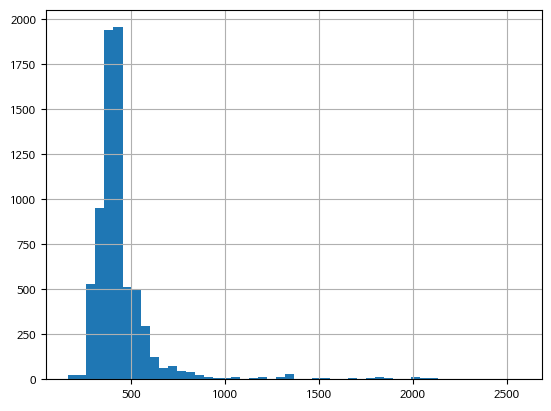

In [ ]:
X_num['CO2 농도'].hist(bins=50)

<Axes: >

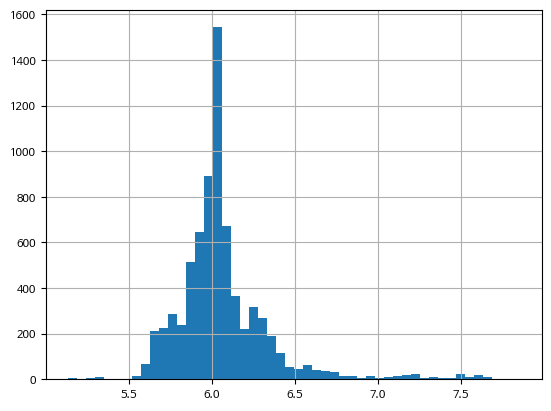

In [ ]:
np.log1p(X_num['CO2 농도']).hist(bins=50)

### 4.4 전체 데이터 준비(4)

In [ ]:
# 범주형 + 수치형
# X_cat_oh + X_num_std

X_cat_oh.shape, X_num_std.shape

((7280, 5), (7280, 9))

In [ ]:
X_prepared = np.concatenate([X_num_std.values, X_cat_oh.values], axis=1)
X_prepared.shape

(7280, 14)

In [ ]:
X_prepared

array([[ 1.24693153, -0.95053175, -0.30863083, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.13311462, -0.60398349, -0.28393391, ...,  0.        ,
         1.        ,  0.        ],
       [-0.38065035,  0.71837172, -0.14069174, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.41479543,  0.56333697, -0.29381268, ...,  0.        ,
         0.        ,  1.        ],
       [-0.27821513,  0.39462269, -0.36296407, ...,  0.        ,
         0.        ,  1.        ],
       [-0.30097851,  0.38094315, -0.34814591, ...,  0.        ,
         0.        ,  1.        ]])

In [ ]:
feature_names = list(X_num_std.columns) + list(X_cat_oh.columns)

## 5. 데이터 세트 분리
- 훈련 데이터/ 테스트 데이터

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_prepared, # 특성
                                                    y_enc, # 정답
                                                    test_size = 0.1, # 비율
                                                    stratify = y_enc,
                                                    random_state = 42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6552, 14), (728, 14), (6552,), (728,))

## 6. 모델 선택과 훈련

```
인스턴스 = 모델객체() # 모델 생성
인스턴스.fit(훈련용특성데이터, 정답) # 모델 훈련
인스턴스.predict(테스트용특성데이터) # 모델 예측 -> predict말고 교차검증으로 하기

````

- KNeighborsClassifier

In [ ]:
knn_clf = KNeighborsClassifier()
knn_scores = cross_val_score(knn_clf, X_train, y_train, scoring='accuracy', cv=5)
knn_scores.mean()

np.float64(0.9270459587401959)

- DecisionTreeClassifier

In [ ]:
tree_clf = DecisionTreeClassifier()
tree_scores = cross_val_score(tree_clf, X_train, y_train, scoring='accuracy', cv=5)
tree_scores.mean()

np.float64(0.9331510821527766)

- DecisionTree 모델 시각화

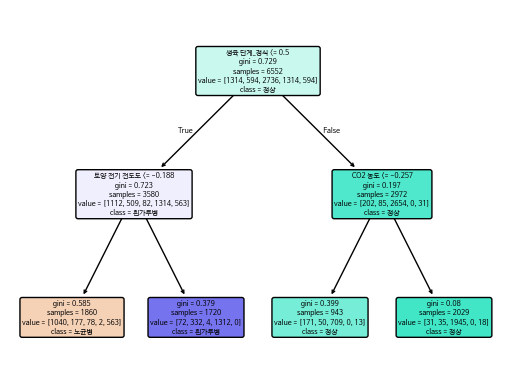

In [ ]:
from sklearn.tree import plot_tree
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X_train, y_train)

plot_tree(tree_clf,
          feature_names=feature_names,
          class_names=y_category,
          rounded=True, filled=True)
plt.show()

- RandomForesetClassifier

In [ ]:
tree_clf.feature_importances_

array([0.        , 0.        , 0.01847872, 0.        , 0.34041934,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.64110194, 0.        ])

In [ ]:
feature_names

['내부 온도',
 '내부 습도',
 'CO2 농도',
 '일사량',
 '토양 전기 전도도',
 '토양 온도',
 '토양 습도',
 '외부 온도',
 '외부 습도',
 '강수 유무_맑음',
 '강수 유무_비',
 '생육 단계_수확',
 '생육 단계_정식',
 '생육 단계_착과']

- RandomForestClassifier

In [ ]:
rf_clf = RandomForestClassifier()
rf_scores = cross_val_score(rf_clf, X_train, y_train, scoring='accuracy', cv=5)
rf_scores

array([0.93745233, 0.9481312 , 0.93664122, 0.95114504, 0.95114504])

## 7. 모델 세부 튜닝

**그리드탐색**

In [ ]:
rf_clf = RandomForestClassifier()

param = {'n_estimators' : [50, 200, 300]} # 3개 모델이 준비

grid_search = GridSearchCV(rf_clf, param, scoring='accuracy', cv=3) # 3개 모델에 교차 검증 3번 --> 학습과 검증 3*3 -> 9번의 학습과 검증이 이루어짐
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [50, 200, 300]}, scoring='accuracy')

In [ ]:
grid_search.best_params_

{'n_estimators': 300}

In [ ]:
zip(grid_search.cv_results_['mean_test_score']), grid_search.cv_results_['params']

(<zip at 0x78298c079080>,
 [{'n_estimators': 50}, {'n_estimators': 200}, {'n_estimators': 300}])

In [ ]:
best_model = grid_search.best_estimator_
best_model

RandomForestClassifier(n_estimators=300)

## 8. 모델 예측과 성능 평가

In [ ]:
y_pred = best_model.predict(X_test)
# 정확도 : 맞은것/전체
(y_pred == y_test).sum()/len(y_test)

np.float64(0.9505494505494505)

In [ ]:
print(np.mean(y_test == y_pred))

0.9505494505494505
